# Using `gwent` to Calculate Signal-to-Noise Ratios

Here we present a tutorial on how to use `gwent` to calculate SNRs for the instrument models currently implemented (LISA, PTAs, aLIGO, and Einstein Telescope) with the signal being an array of coalescing Binary Black Holes.

First, we import important modules.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import astropy.constants as const
import time
import astropy.units as u

import os,sys
current_path = os.getcwd()
splt_path = current_path.split("/")
top_path_idx = splt_path.index('gwent')
top_directory = "/".join(splt_path[0:top_path_idx+1])

sys.path.insert(0,top_directory)
import gwent
import gwent.binary as binary
import gwent.detector as detector
import gwent.snr as snr
import gwent.snrplot as snrplot

Setting matplotlib preferences

In [3]:
mpl.rcParams['figure.dpi'] = 300
mpl.rcParams['figure.figsize'] = [5,3]
mpl.rcParams['text.usetex'] = True
mpl.rc('font',**{'family':'serif','serif':['Times New Roman'],'size':14})

We need to get the file directories to load in the instrument files.

In [4]:
load_directory = gwent.__path__[0] + '/LoadFiles/InstrumentFiles/'

## Declaring x and y variables and Sample Rates

The variables for either axis in the SNR calculation can be:

* GLOBAL:

    * 'T_obs' - Detector Observation Time
    
* SOURCE:

    * 'M' - Mass (Solar Units)
    * 'q' - Mass Ratio
    * 'chi1' - Dimensionless Spin of Black Hole 1
    * 'chi2' - Dimensionless Spin of Black Hole 2
    * 'z' - Redshift
    
* LISA ONLY:

    * 'L' - Detector Armlength
    * 'A_acc' - Detector Acceleration Noise
    * 'A_IMS' - Detector Optical Metrology Noise
    * 'f_acc_break_low' - The Low Acceleration Noise Break Frequency
    * 'f_acc_break_high' - The High Acceleration Noise Break Frequency
    * 'f_IMS_break' - The Optical Metrology Noise Break Frequency
    
* PTAs ONLY:

    * 'N_p' - Number of Pulsars
    * 'sigma' - Root-Mean-Squared Timing Error
    * 'cadence' - Observation Cadence

In [5]:
#Variable on y-axis
var_y = 'z'
#Number of SNRMatrix rows
sampleRate_y = 50
#Variable on x-axis
var_x = 'M'
#Number of SNRMatrix columns
sampleRate_x = 50

## Source Selection Function

Takes in a an instrument model that dictates reasonable mass ranges for the particular detector mass regime and instantiates a source with the variable ranges limited by the waveform calibration region.

The source parameters must be set (ie. M,q,z,chi1,chi2), but one only needs to set the minima and maxima of the selected SNR axes variables.

In [6]:
def Get_Source(model):
    if model == 0 or model == 1:
        #M = m1+m2 Total Mass
        M = 1e2
        M_min = 1e0
        M_max = 1e5
    elif model == 2 or model == 3:
        #M = m1+m2 Total Mass
        M = 1e8
        M_min = 1e7
        M_max = 1e11
    else:
        #M = m1+m2 Total Mass
        M = 1e6
        M_min = 1e1
        M_max = 1e10
        
    #q = m2/m1 reduced mass
    q = 1.0
    q_min = 1.0
    q_max = 18.0

    #Chi = S_i*L/m_i**2, spins of each mass i
    chi1 = 0.0 #spin of m1
    chi2 = 0.0 #spin of m2
    chi_min = -0.85 #Limits of PhenomD for unaligned spins
    chi_max = 0.85
    
    z = 3.0 #Redshift
    z_min = 1e-2
    z_max = 1e3
    
    source = binary.BBHFrequencyDomain(M,q,z,chi1,chi2)
    source.M = [M,M_min,M_max]
    source.q = [q,q_min,q_max]
    source.chi1 = [chi1,chi_min,chi_max]
    source.chi2 = [chi2,chi_min,chi_max]
    source.z = [z,z_min,z_max]

    return source

## Instrument Selection Function

Takes in an instrument model then assigns the fiducial noise and detector values. The model only assigns ranges of calculation for quick variable calculations, but one only needs to set the minima and maxima if they wish to use other selected SNR axes variables.

If loading a detector, the file should be frequency in the first column and either strain, effective strain noise spectral density, or amplitude spectral density in the second column.

For generating a detector, one must assign a value to each of the different instrument parameters (see the section on Declaring x and y variables and Sample Rates).

In [7]:
def Get_Instrument(model):
    if model == 0: #Einstein Telescope
        #Loaded from http://www.et-gw.eu/index.php/etsensitivities
        load_name = 'ET_D_data.txt'
        load_location = load_directory + 'EinsteinTelescope/StrainFiles/' + load_name
        
        T_obs = 4*u.yr #Observing time in years
        T_obs_min = 1*u.yr
        T_obs_max = 10*u.yr
        
        instrument = detector.GroundBased('ET',T_obs,load_location=load_location,I_type='A')
        instrument.T_obs = [T_obs,T_obs_min,T_obs_max]

    elif model == 1: #aLIGO
        #Loaded from https://dcc.ligo.org/T1800044/public
        load_name = 'aLIGODesign.txt'
        load_location = load_directory + 'aLIGO/StrainFiles/' + load_name
        
        T_obs = 4*u.yr #Observing time in years
        T_obs_min = 1*u.yr
        T_obs_max = 10*u.yr

        instrument = detector.GroundBased('aLIGO',T_obs,load_location=load_location,I_type='A')
        instrument.T_obs = [T_obs,T_obs_min,T_obs_max]

    elif model == 2: #NANOGrav 15 yr
        #NANOGrav calculation using 11.5yr parameters https://arxiv.org/abs/1801.01837
        T_obs = 15*u.yr #Observing time in years
        T_obs_min = 10*u.yr
        T_obs_max = 30*u.yr

        sigma = 100*u.ns.to('s')*u.s #rms timing residuals in seconds
        
        N_p = 18 #Number of pulsars
        
        cadence = 1/(2*u.wk.to('yr')*u.yr) #Avg observation cadence of 1 every 2 weeks in num/year
        
        instrument = detector.PTA('NANOGrav',T_obs,N_p,sigma,cadence)
        instrument.T_obs = [T_obs,T_obs_min,T_obs_max]

        
    elif model == 3: #SKA (2030s)
        #SKA calculation using parameters and methods from https://arxiv.org/abs/0804.4476 section 7.1
        T_obs = 15*u.yr #Observing time (years)
        T_obs_min = 10*u.yr
        T_obs_max = 30*u.yr
        
        sigma = 10*u.ns.to('s')*u.s #rms timing residuals in nanoseconds
        
        N_p = 20 #Number of pulsars
        
        cadence = 1/(u.wk.to('yr')*u.yr) #Avg observation cadence of 1 every week in num/year
        
        instrument = detector.PTA('SKA',T_obs,N_p,sigma,cadence)
        instrument.T_obs = [T_obs,T_obs_min,T_obs_max]
        
    elif model == 4: #Robson,Cornish,and Liu 2019, LISA (https://arxiv.org/abs/1803.01944)
        T_obs = 4*u.yr #Observing time in years
        T_obs_min = 1*u.yr
        T_obs_max = 10*u.yr

        L = 2.5e9*u.m #armlength in meters
        L_min = 1.0e7*u.m
        L_max = 1.0e11*u.m
          
        A_acc = 3e-15*u.m/u.s/u.s #M/s**2
        A_IMS = 1.5e-11*u.m
        f_IMS_break = 2.*u.mHz.to('Hz')*u.Hz
        f_acc_break_low = .4*u.mHz.to('Hz')*u.Hz
        f_acc_break_high = 8.*u.mHz.to('Hz')*u.Hz
        Background = False
        T_type = 'A'
        
        instrument = detector.SpaceBased('Alt_LISA',\
                                       T_obs,L,A_acc,f_acc_break_low,f_acc_break_high,A_IMS,f_IMS_break,\
                                       Background=Background,T_type=T_type)
        instrument.T_obs = [T_obs,T_obs_min,T_obs_max]
        instrument.L = [L,L_min,L_max]
        
    else: #L3 proposal
        #Default Params from https://arxiv.org/abs/1702.00786
        T_obs = 4*u.yr #Observing time in years
        T_obs_min = 1*u.yr
        T_obs_max = 10*u.yr
        
        L = 2.5e9*u.m #armlength in meters
        L_min = 1.0e7*u.m
        L_max = 1.0e11*u.m
        
        f_acc_break_low = .4*u.mHz.to('Hz')*u.Hz
        f_acc_break_high = 8.*u.mHz.to('Hz')*u.Hz
        f_IMS_break = 2.*u.mHz.to('Hz')*u.Hz
        A_acc = 3e-15*u.m/u.s/u.s
        A_IMS = 10e-12*u.m
        Background = False
        T_type = 'N'
        
        instrument = detector.SpaceBased('LISA_ESA',\
                                       T_obs,L,A_acc,f_acc_break_low,f_acc_break_high,A_IMS,f_IMS_break,\
                                       Background=Background,T_type=T_type)
        instrument.T_obs = [T_obs,T_obs_min,T_obs_max]
        instrument.L = [L,L_min,L_max]
        
    return instrument

## SNR Calculation

Based on the selected model, we use `Get_Instrument` and `Get_Source` to instantiate both the instrument and the model for the SNR Calculation.

In [8]:
model = 2
instrument = Get_Instrument(model)
source = Get_Source(model)

We now use `Get_SNR_Matrix` with the variables given and the data range to sample the space either logrithmically or linearly based on the selection of variables. 
It computes the SNR for each value, then returns the variable ranges used to calculate the SNR for each matrix, then returns the SNRs with size of the `sampleRate1`X`sampleRate2`

In [9]:
start = time.time()
[sample_x,sample_y,SNRMatrix] = snr.Get_SNR_Matrix(source,instrument,var_x,sampleRate_x,var_y,sampleRate_y)
end = time.time()
print(end-start)

7.860724925994873


Plot the SNR using the initial variables and the returns from `Get_SNR_Matrix`

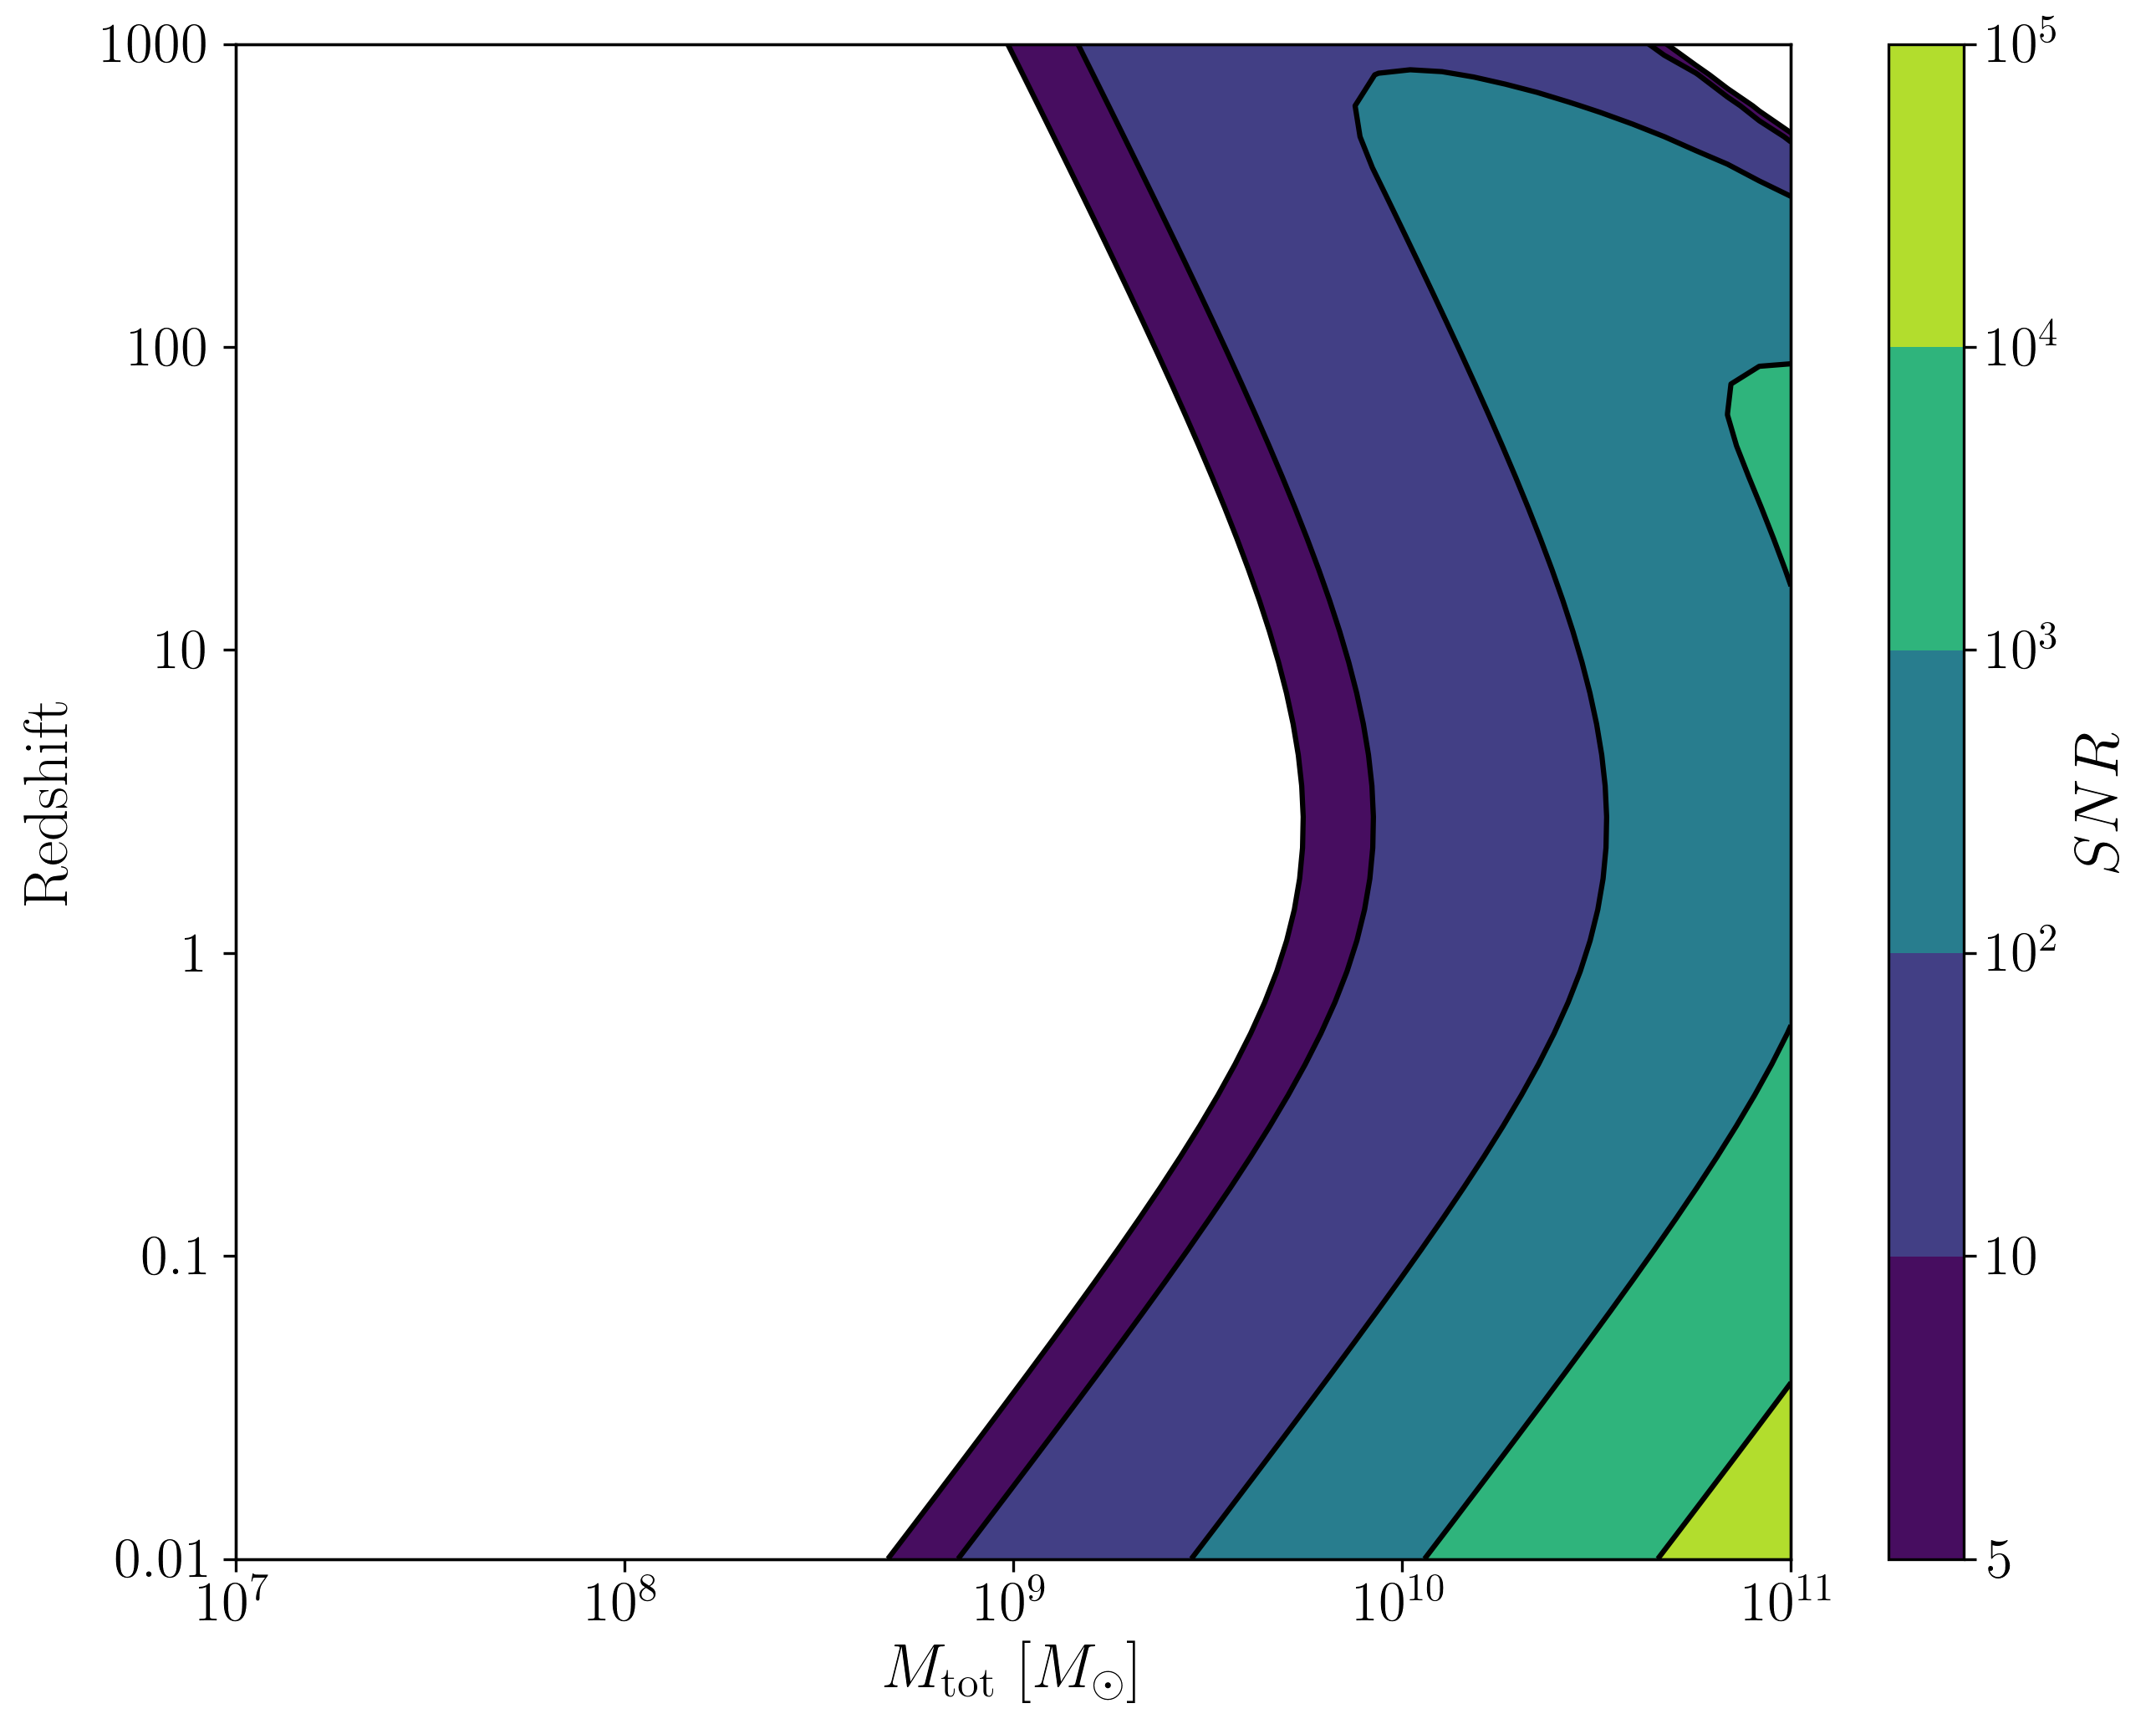

In [10]:
snrplot.Plot_SNR(source,instrument,var_x,sample_x,var_y,sample_y,SNRMatrix,smooth_contours=False)

## Create of SNR Matrices and Samples for all models

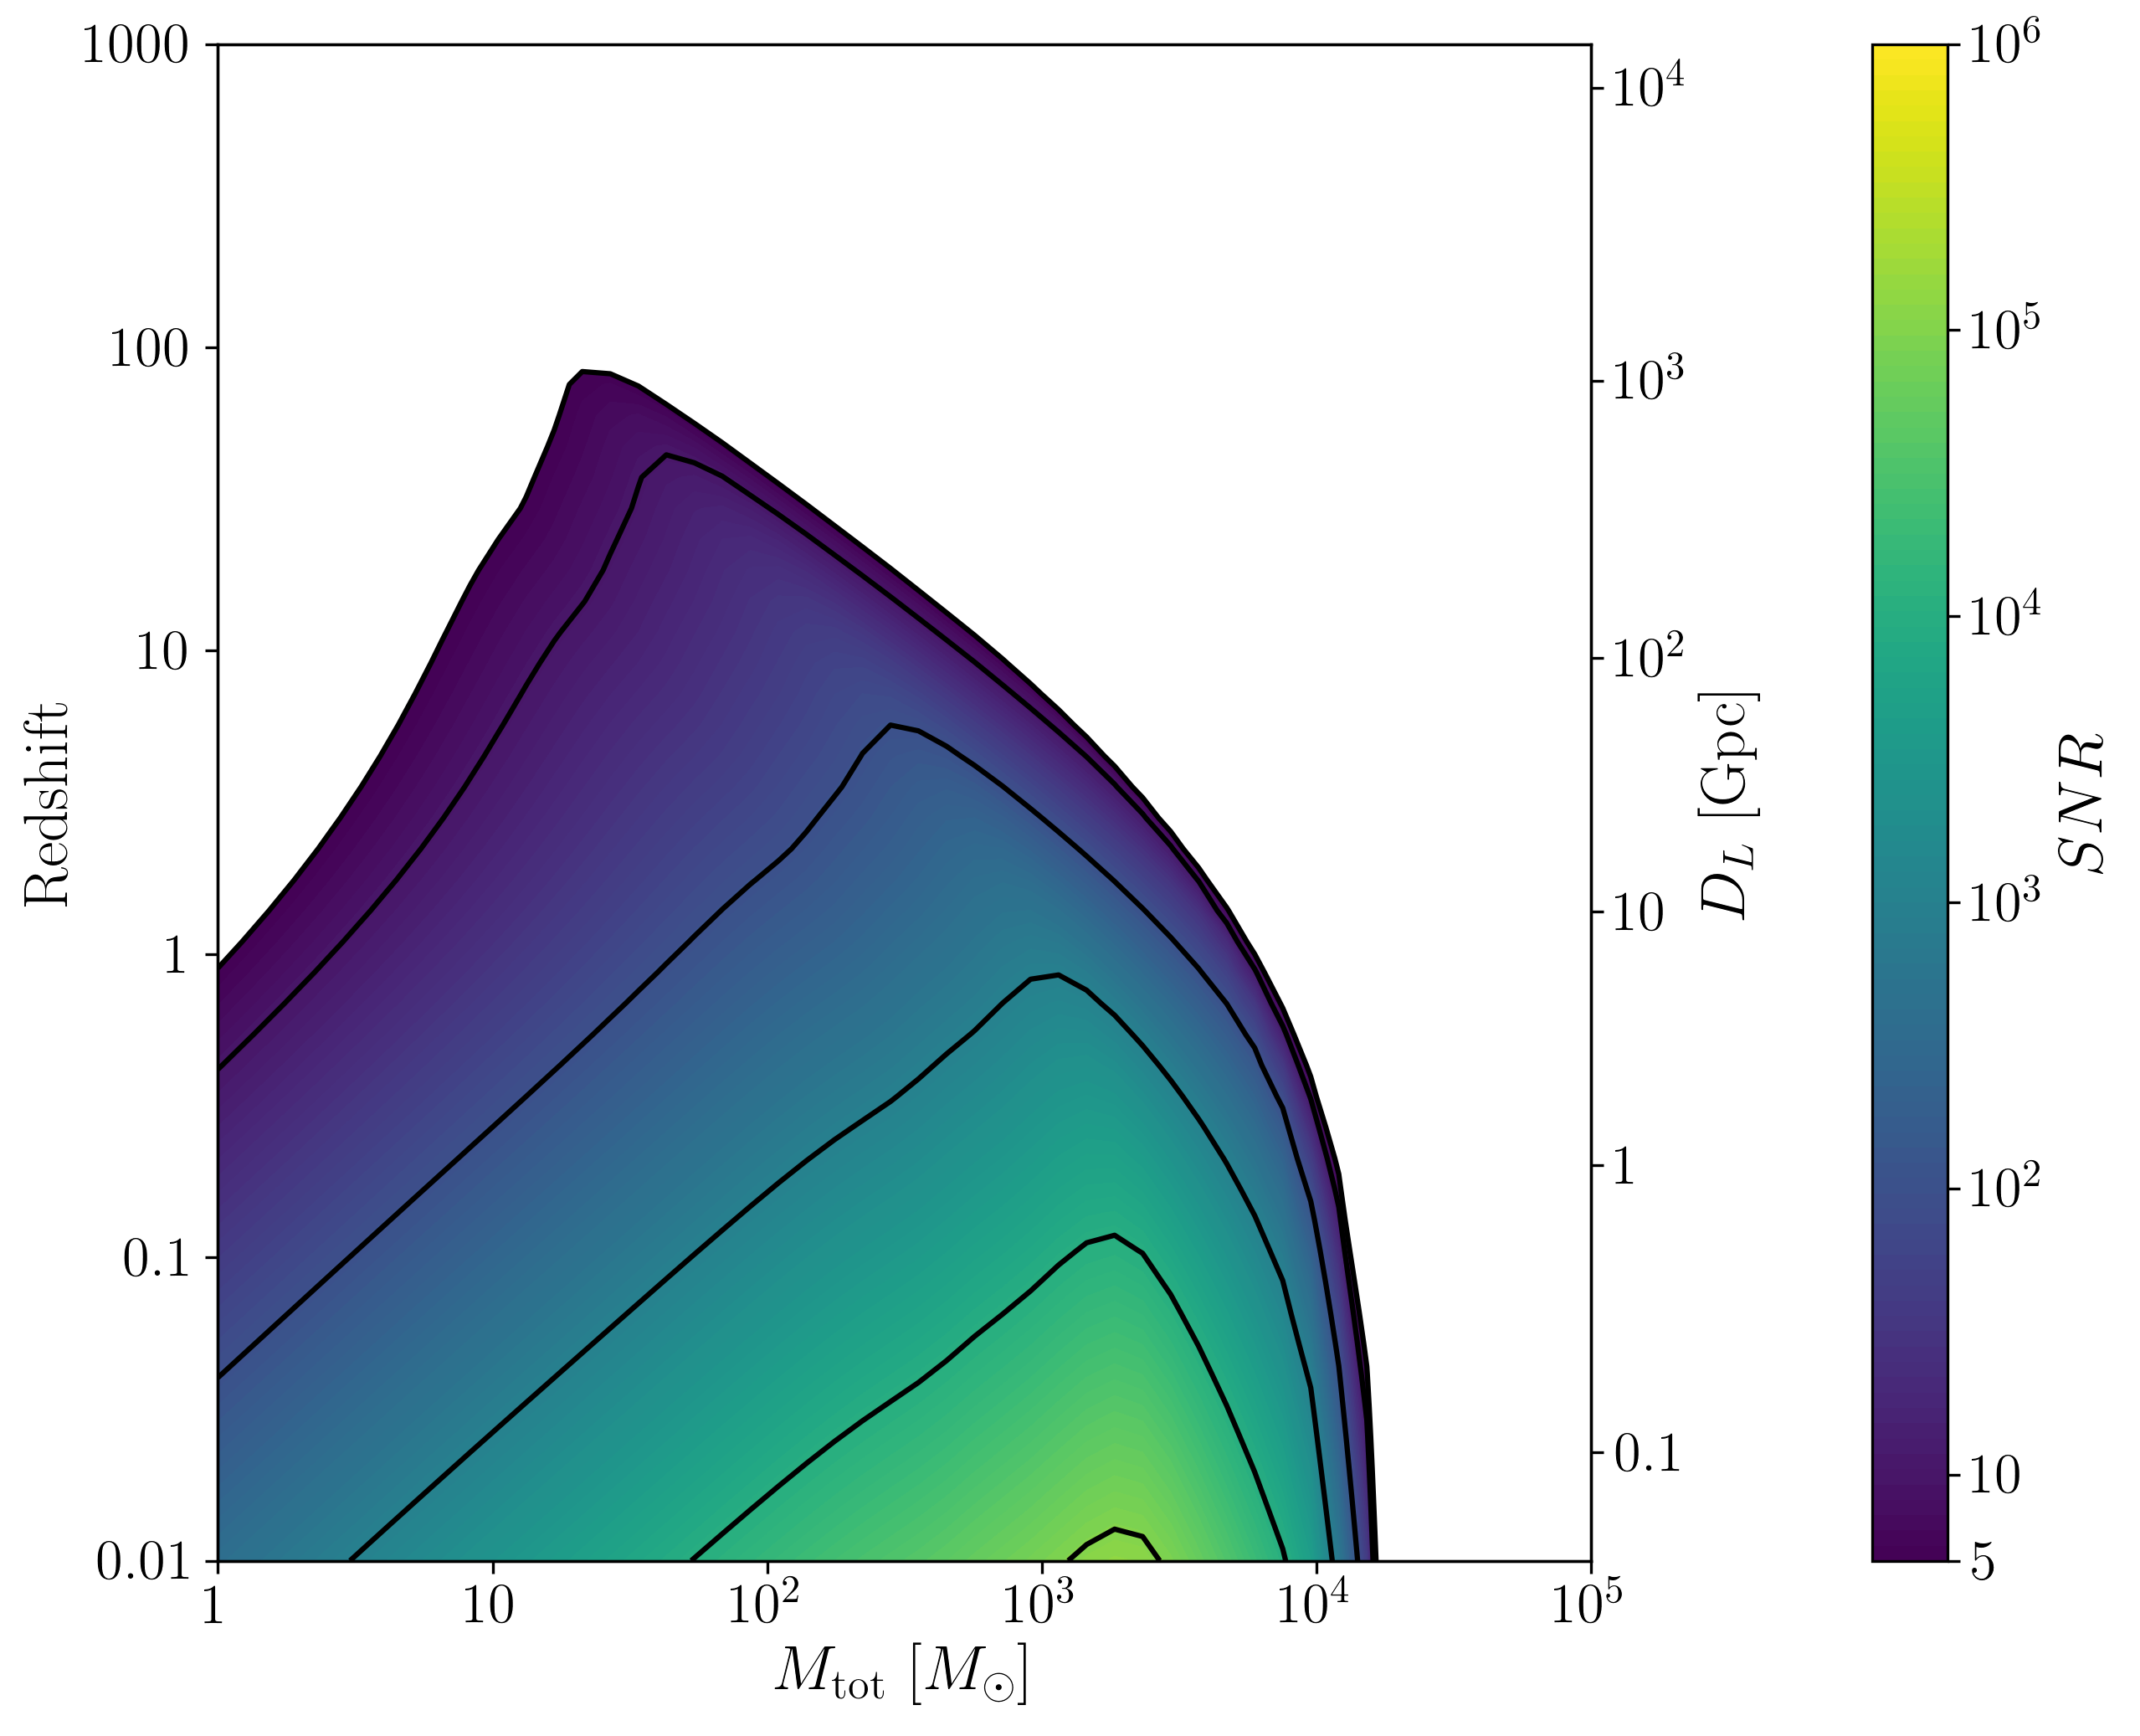

Model:  ET ,  done. t = :  9.078433275222778


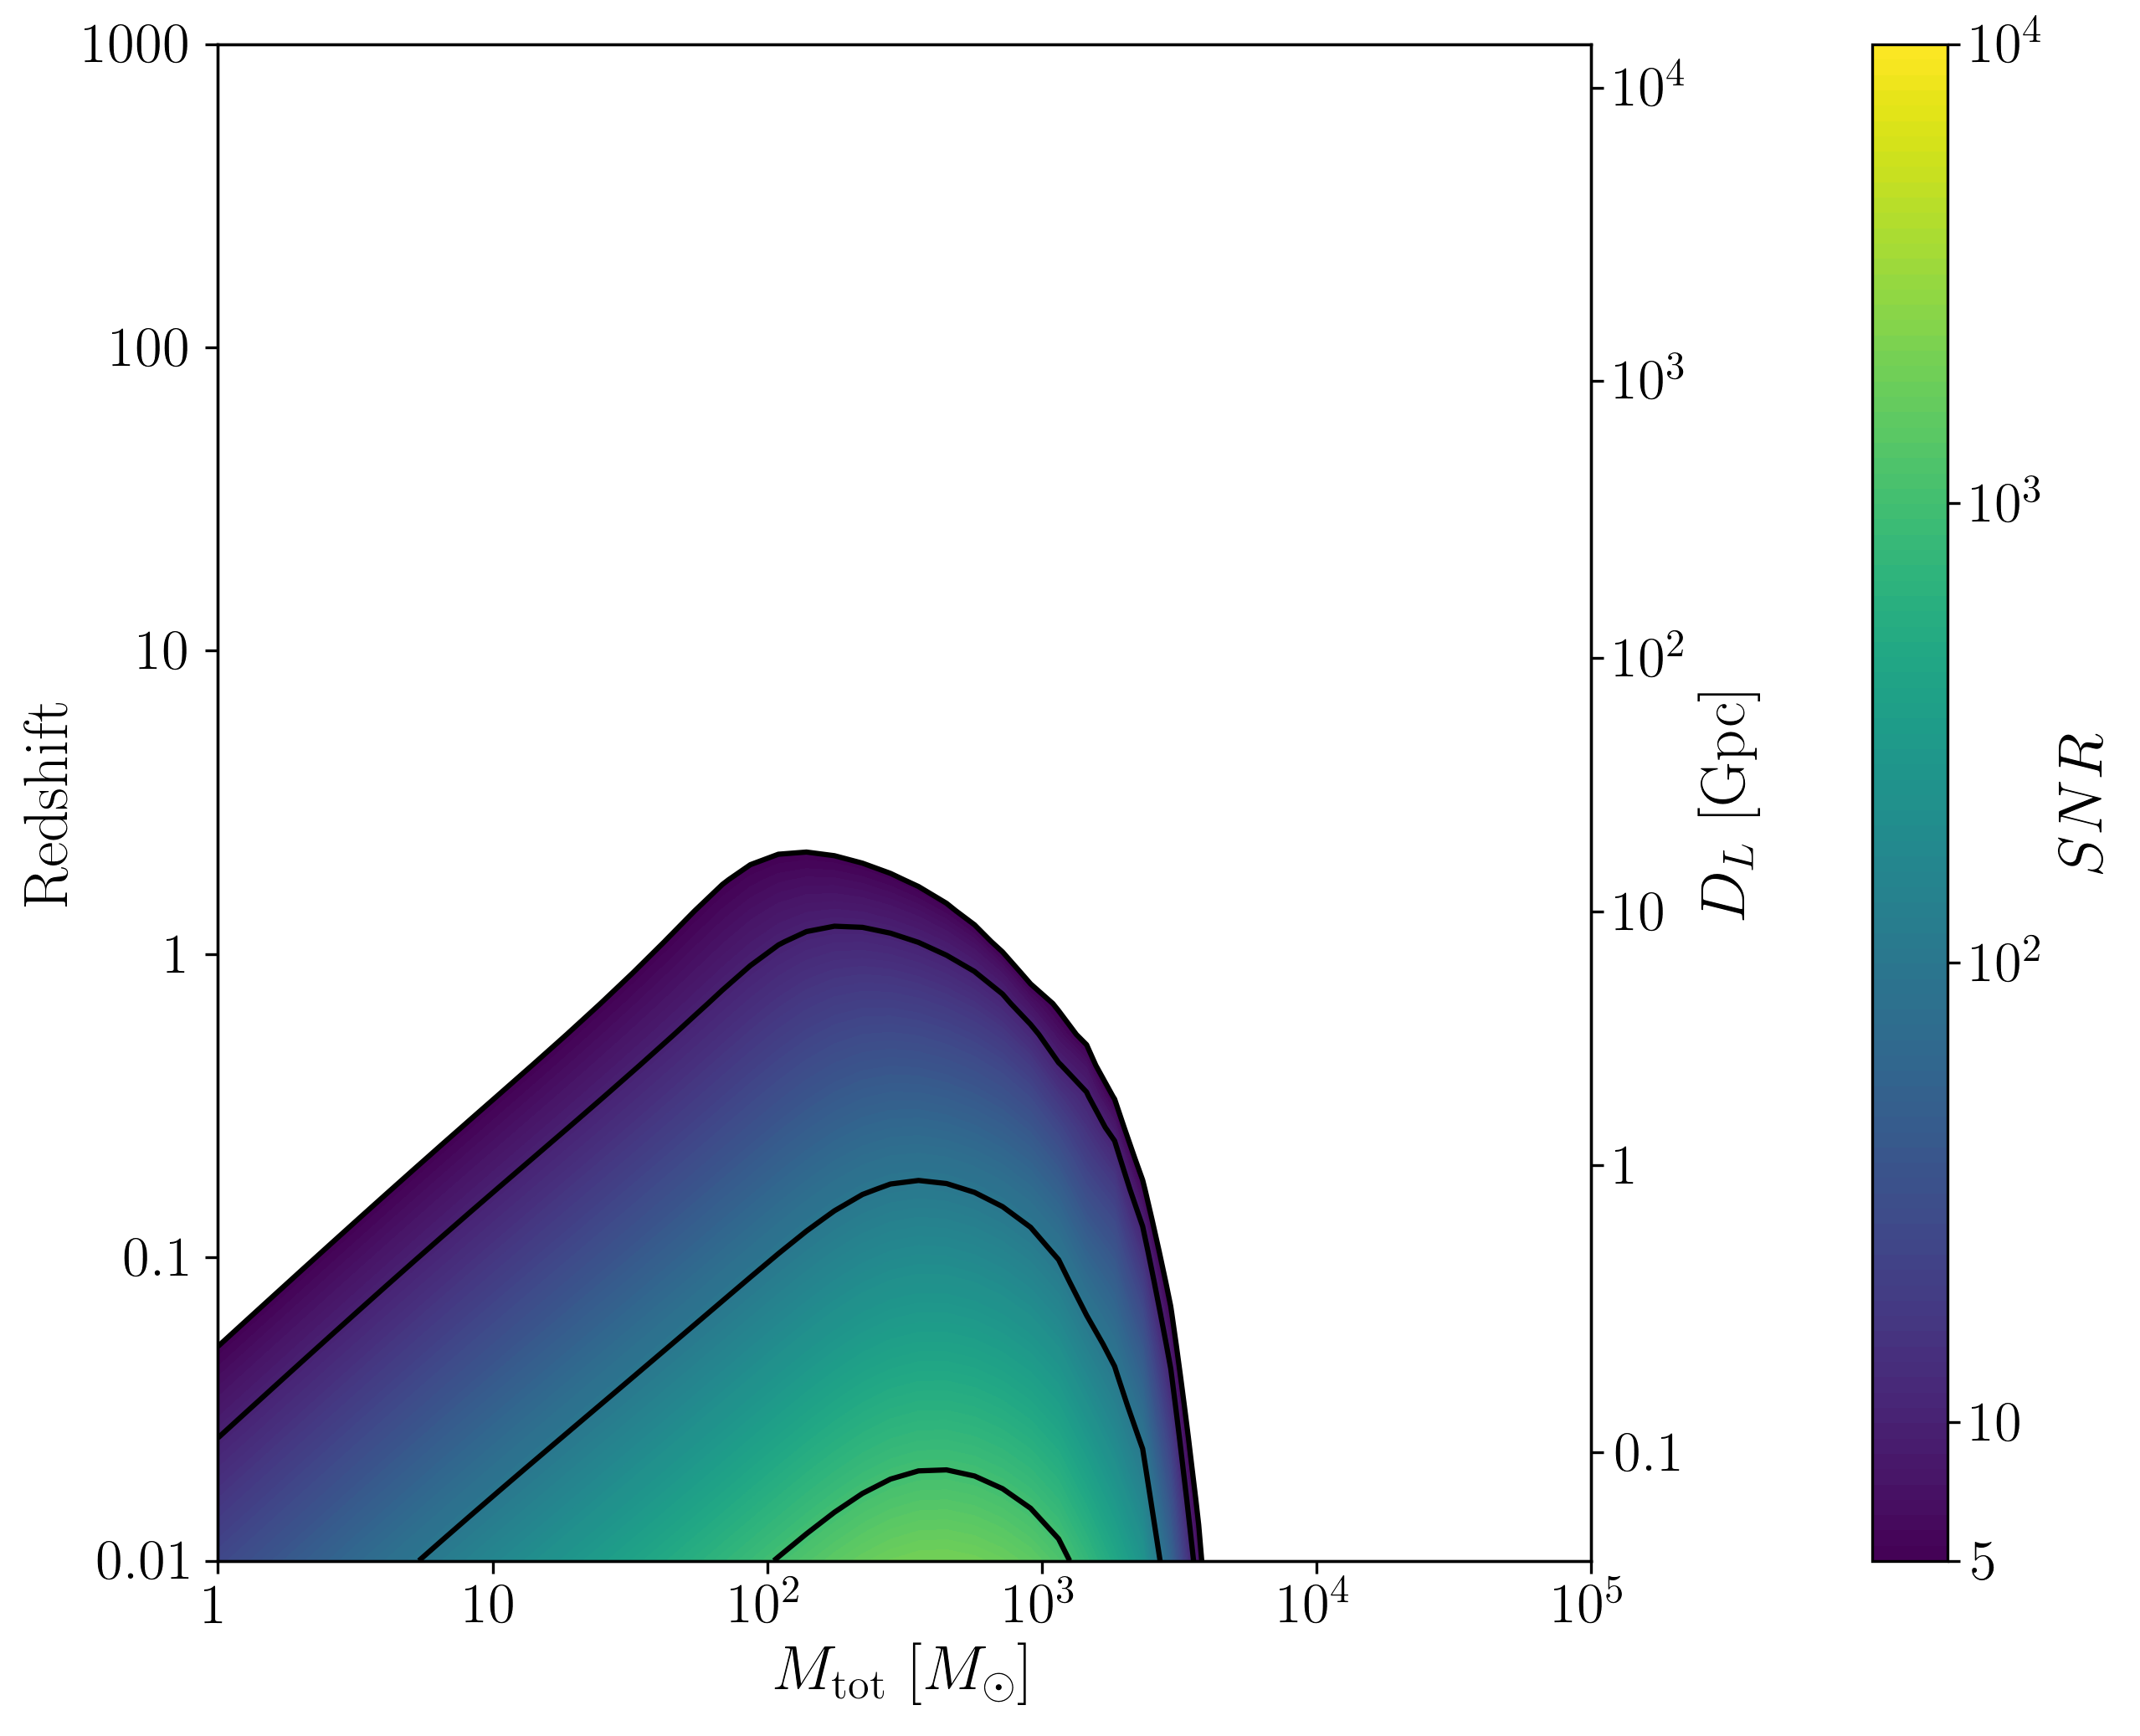

Model:  aLIGO ,  done. t = :  18.534347772598267


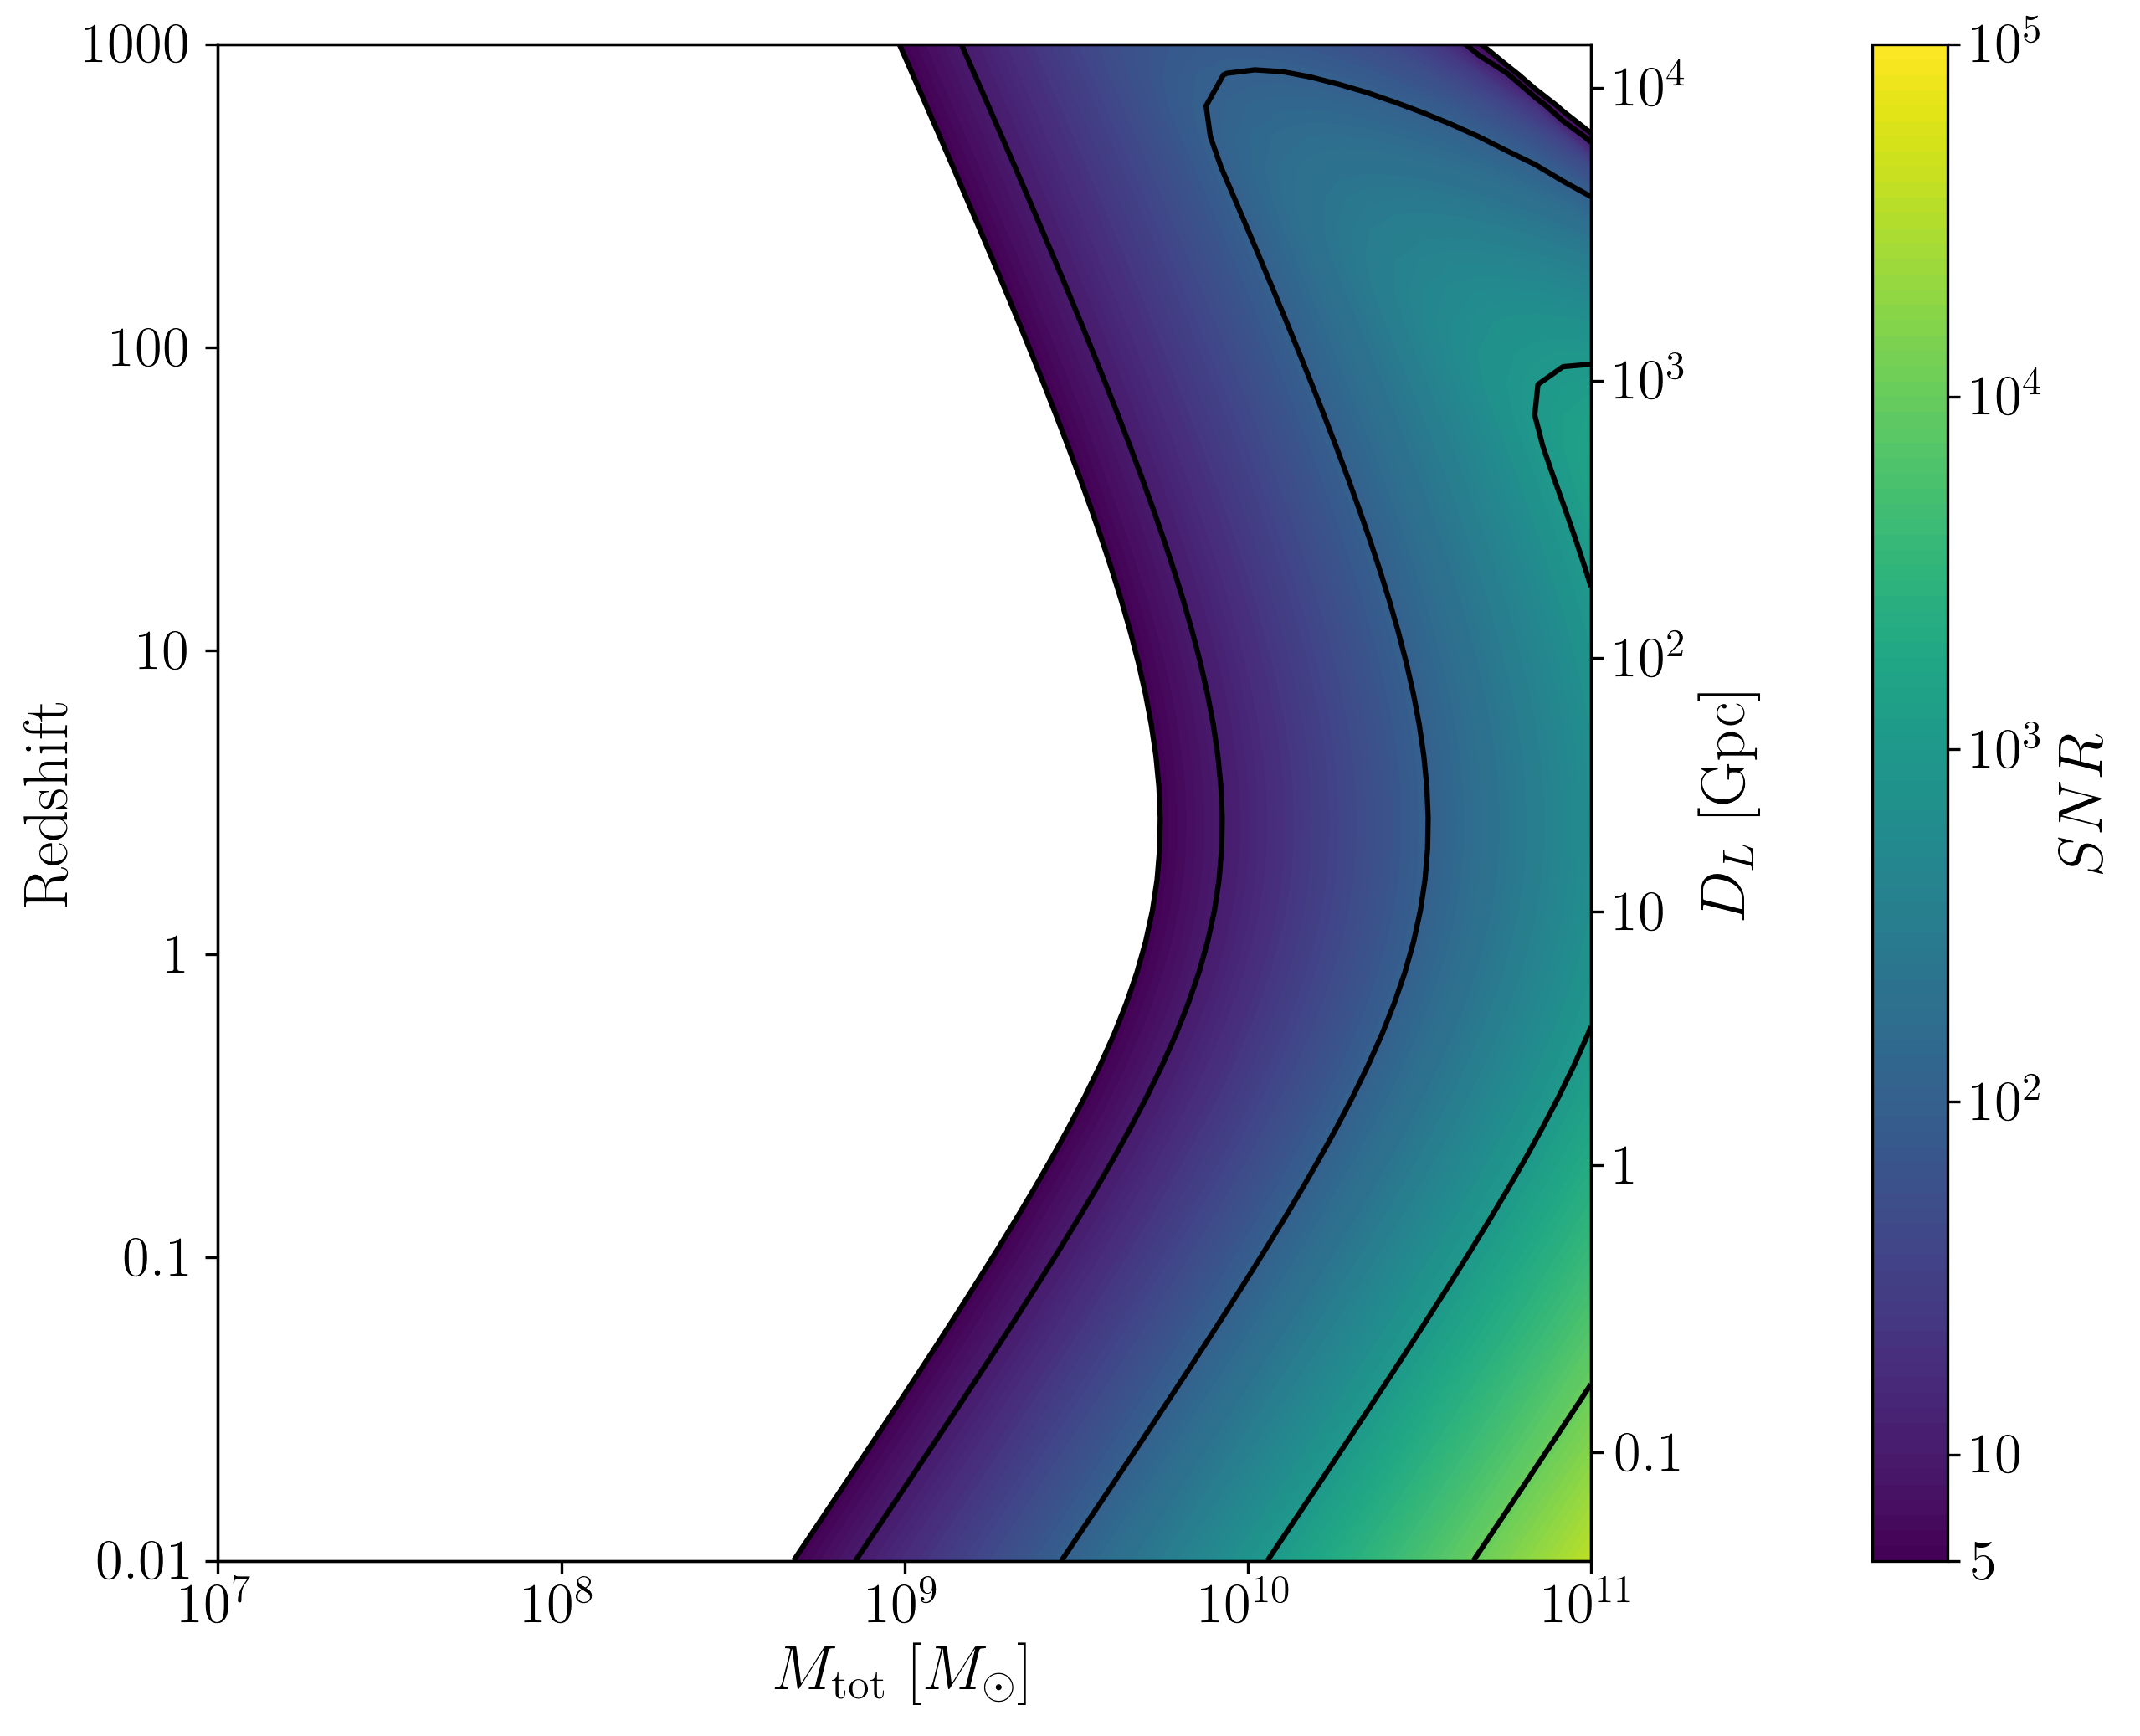

Model:  NANOGrav ,  done. t = :  18.217751264572144


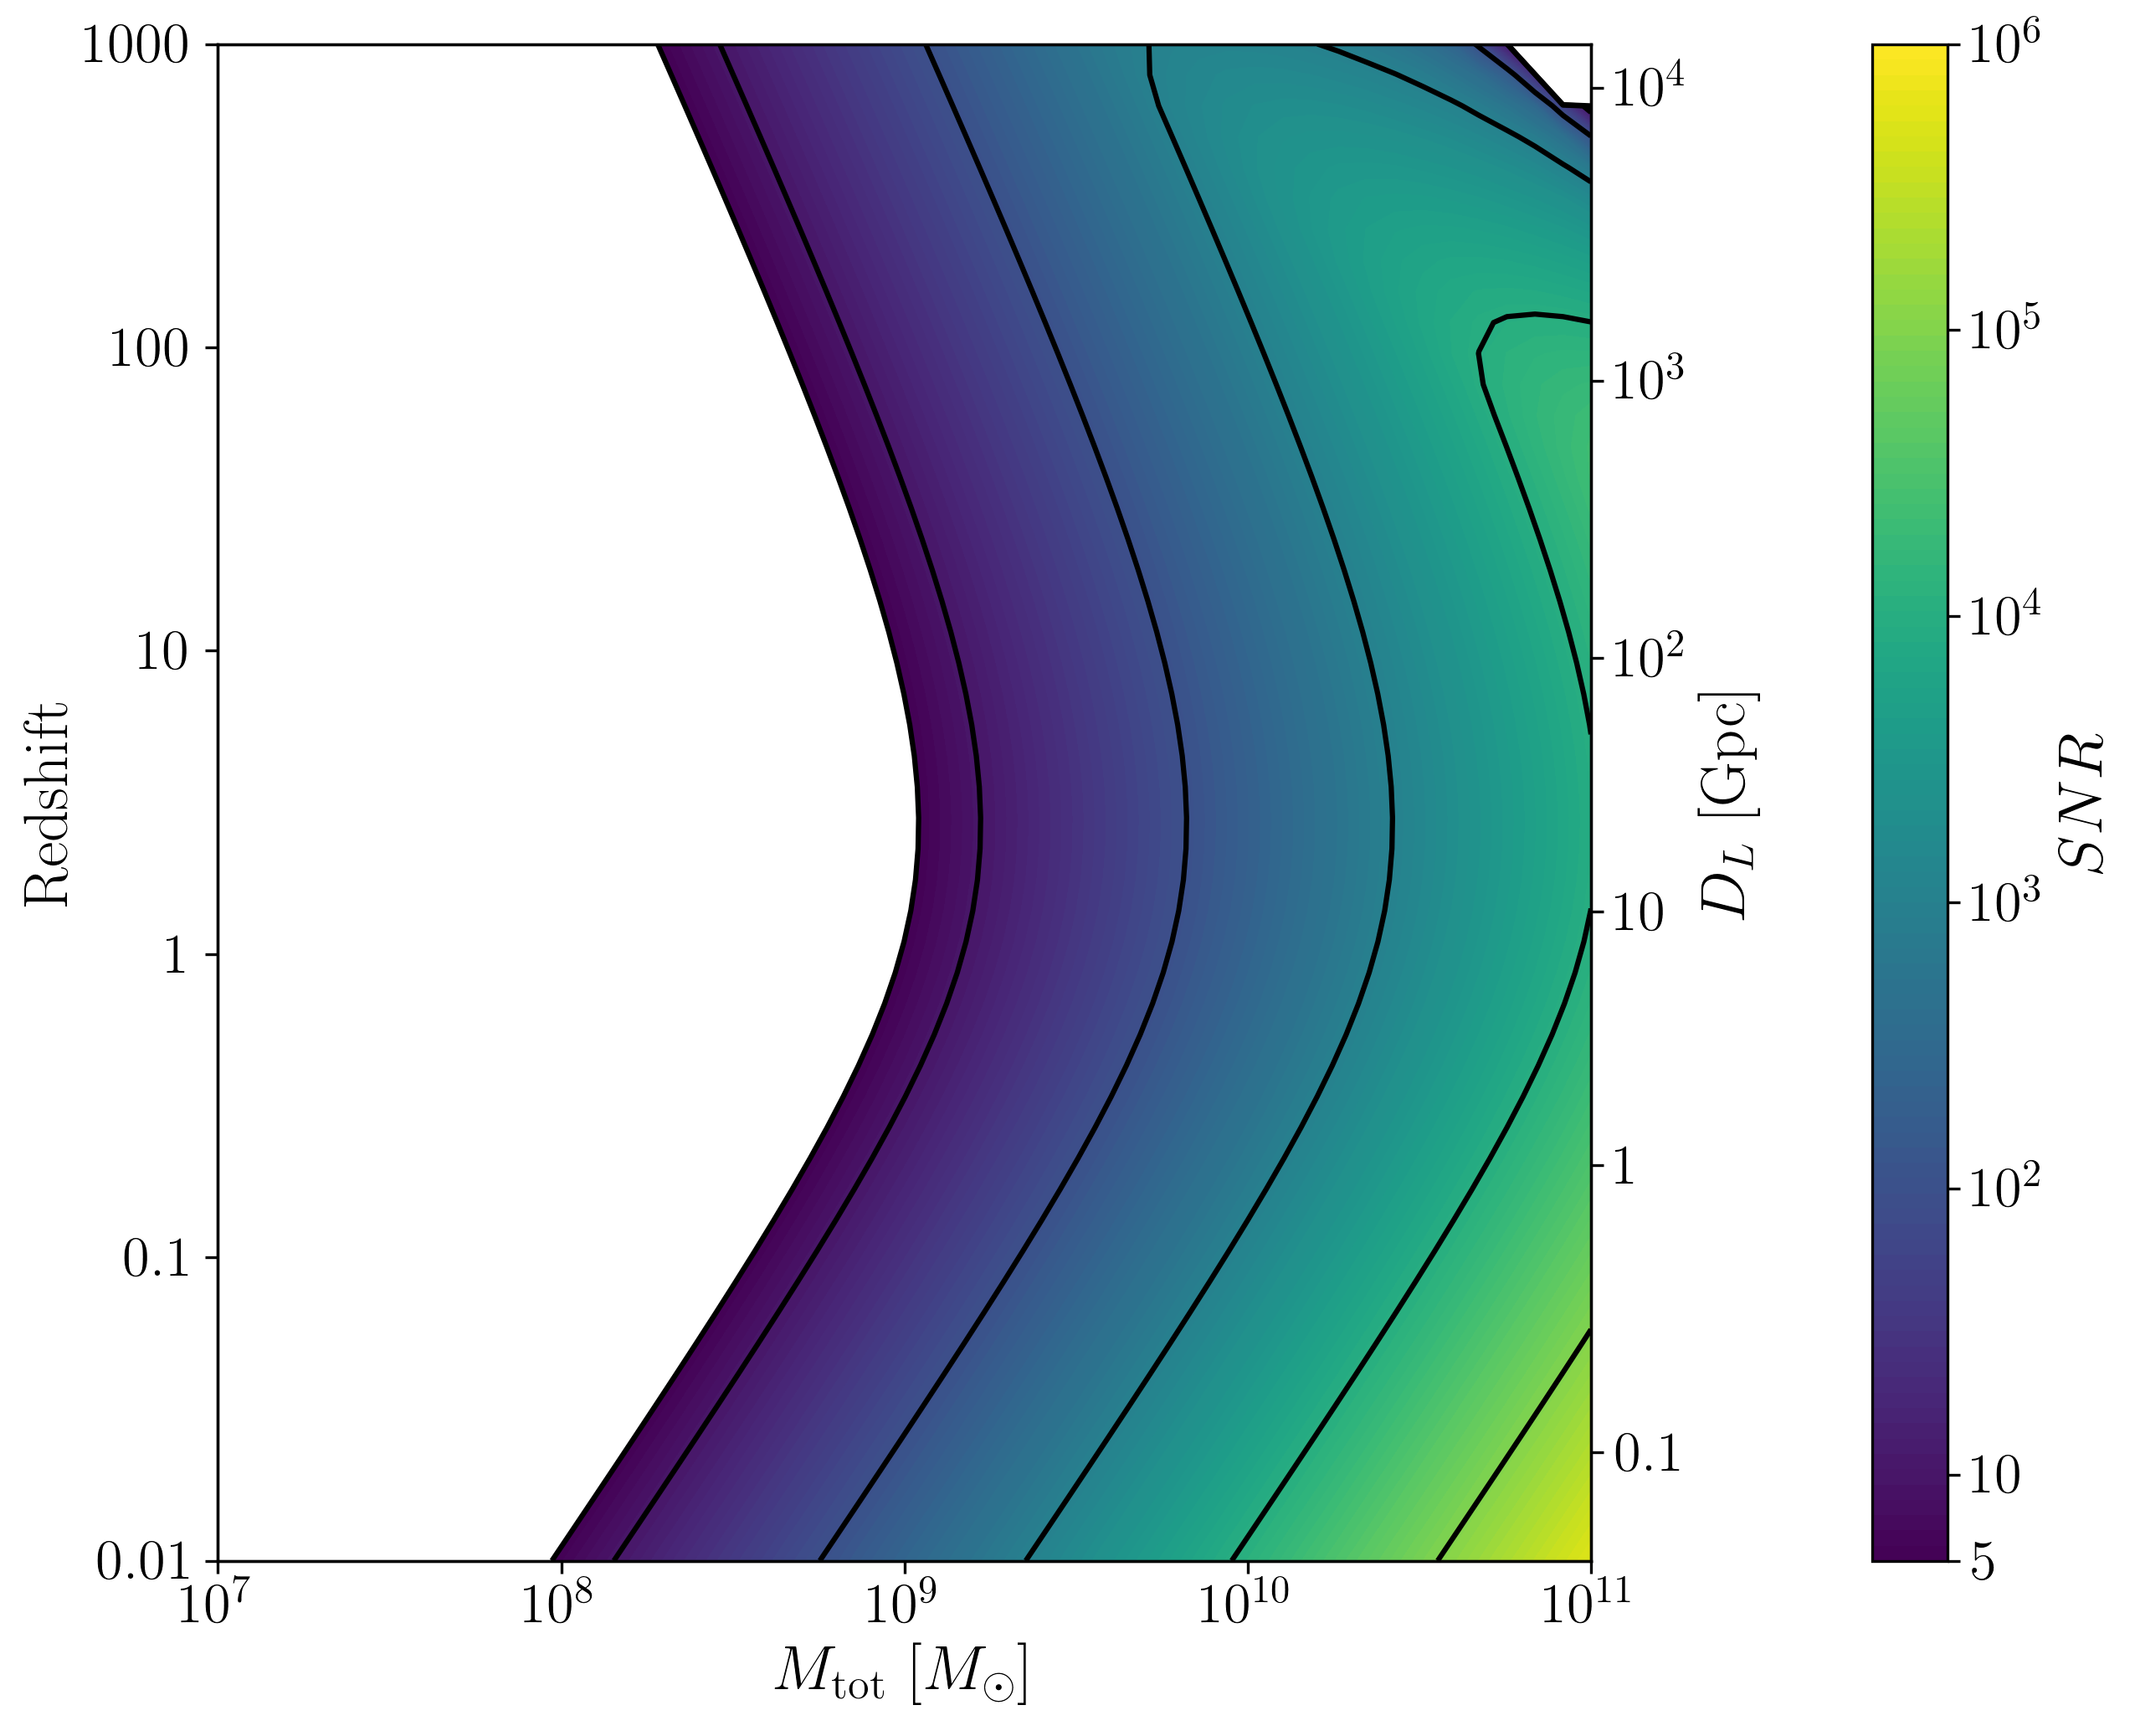

Model:  SKA ,  done. t = :  18.184070348739624


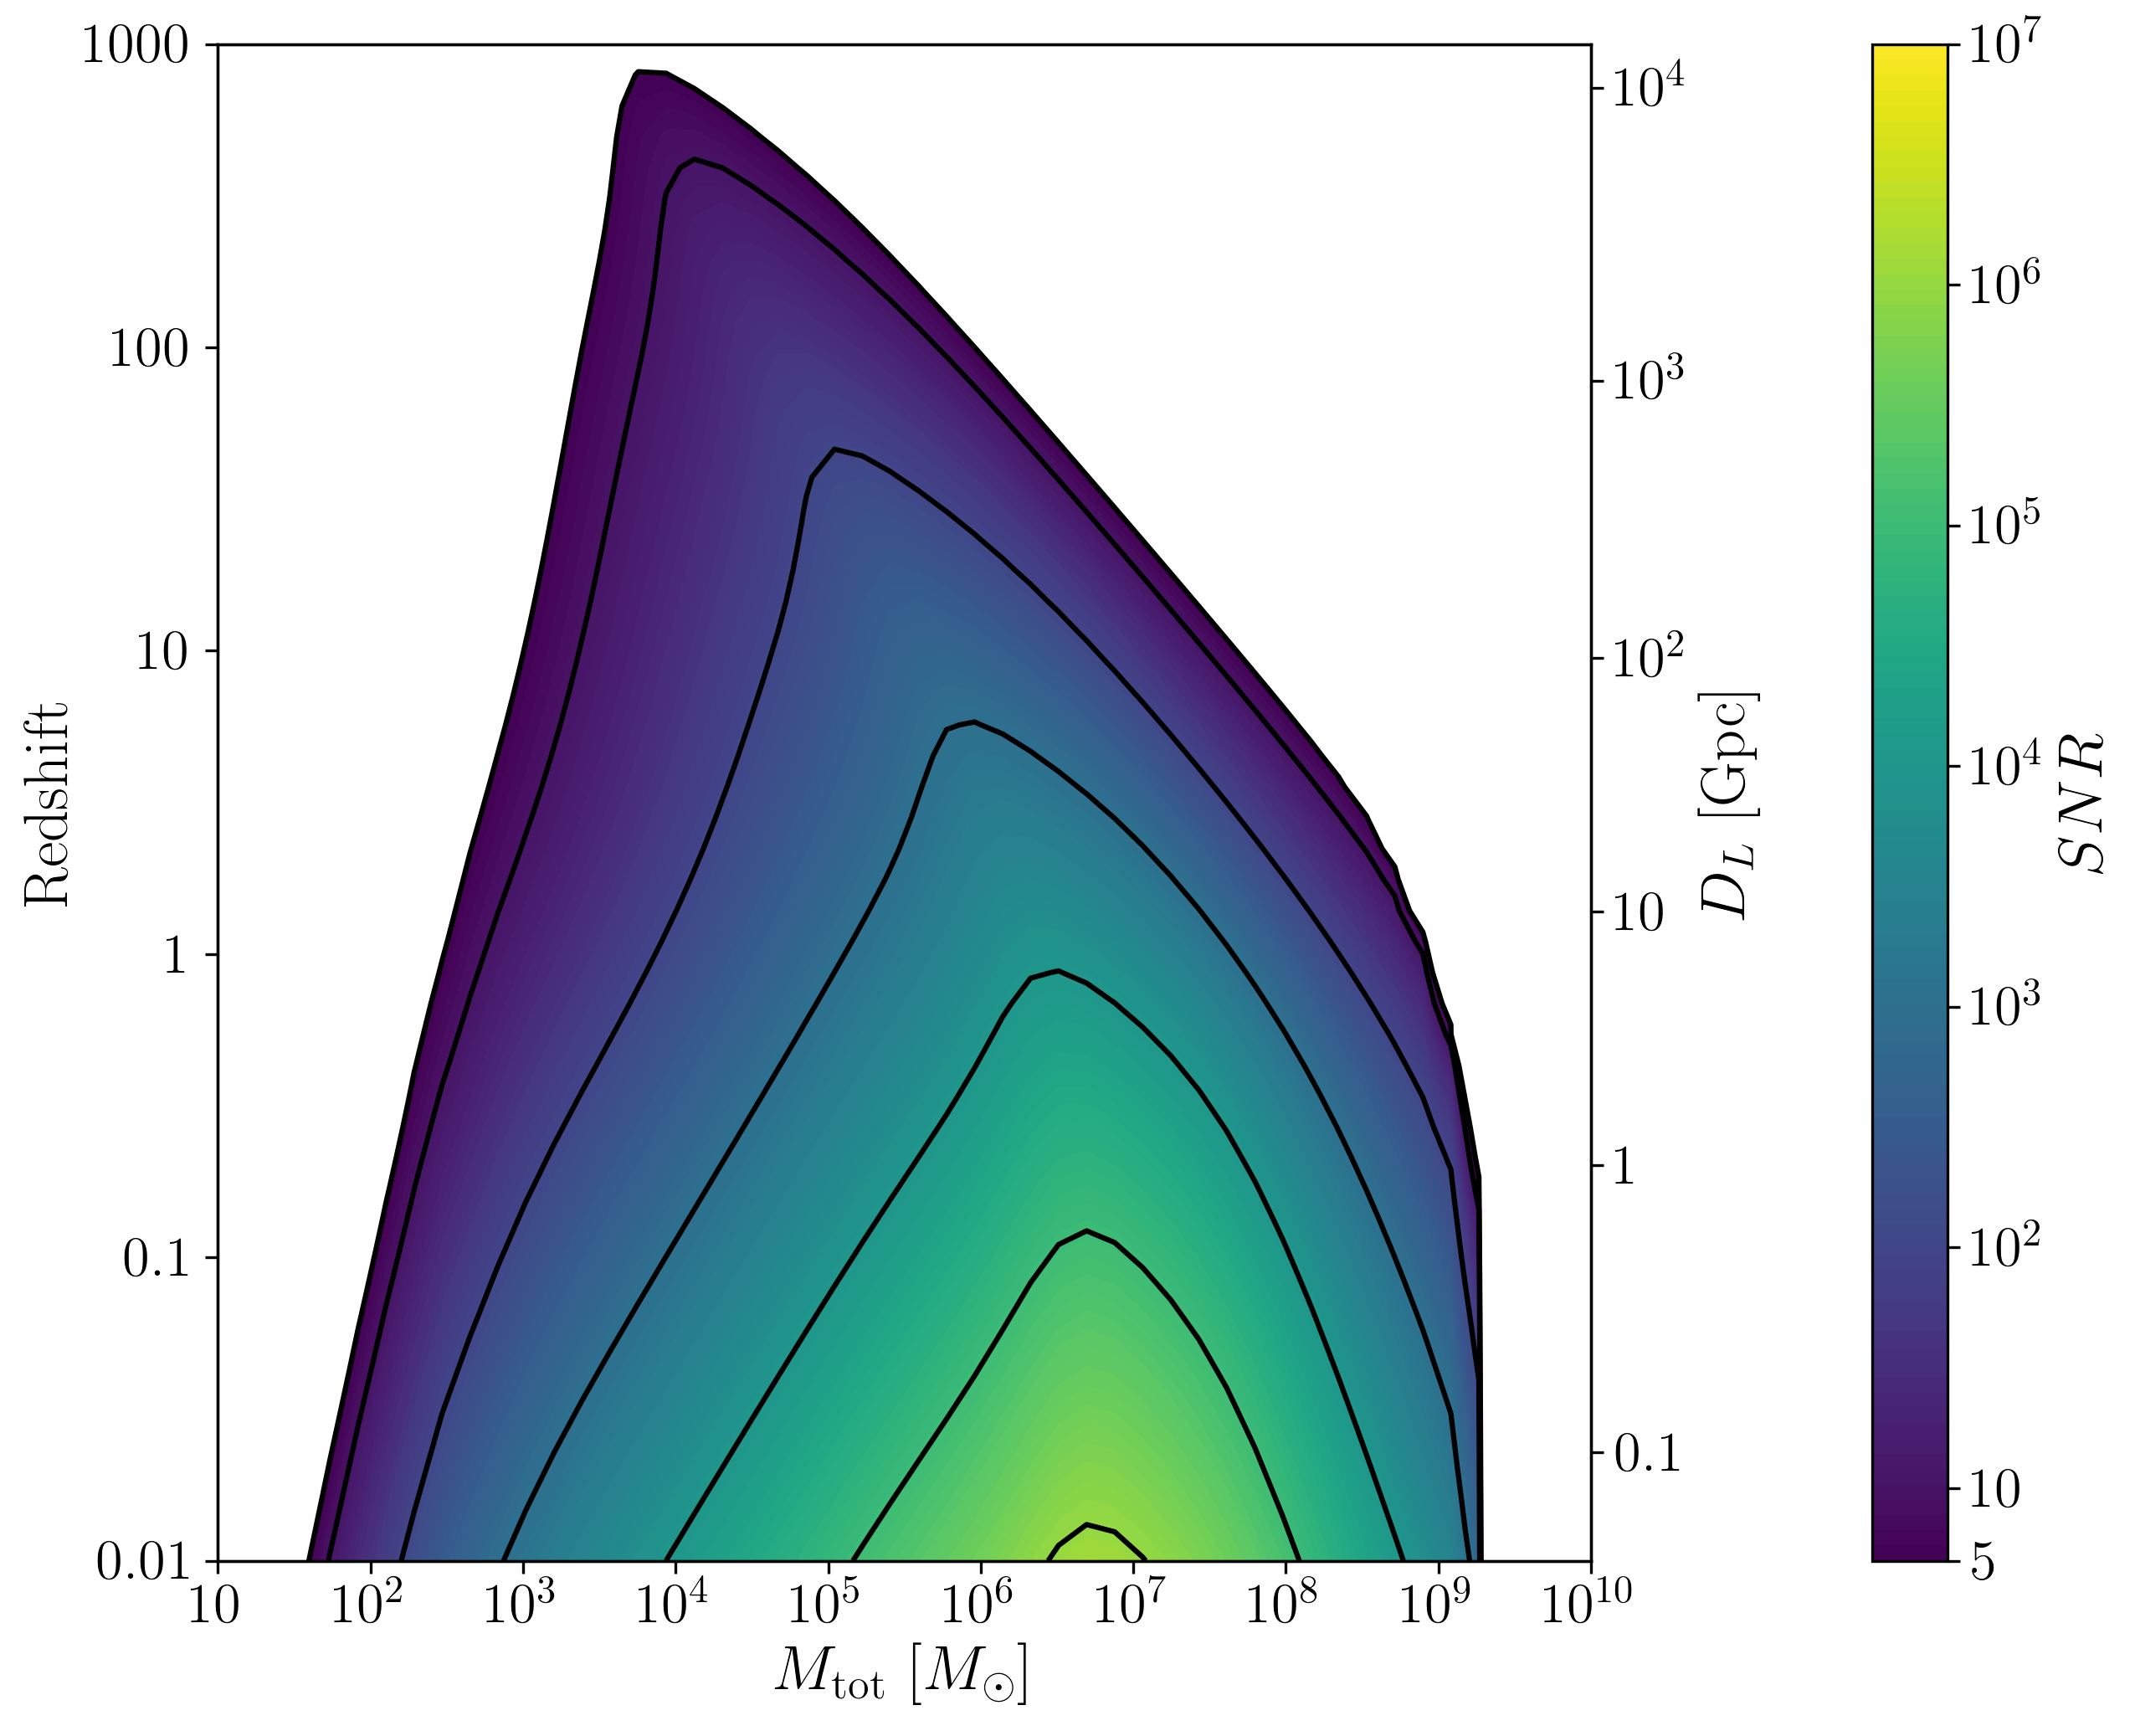

Model:  Alt_LISA ,  done. t = :  7.945163011550903


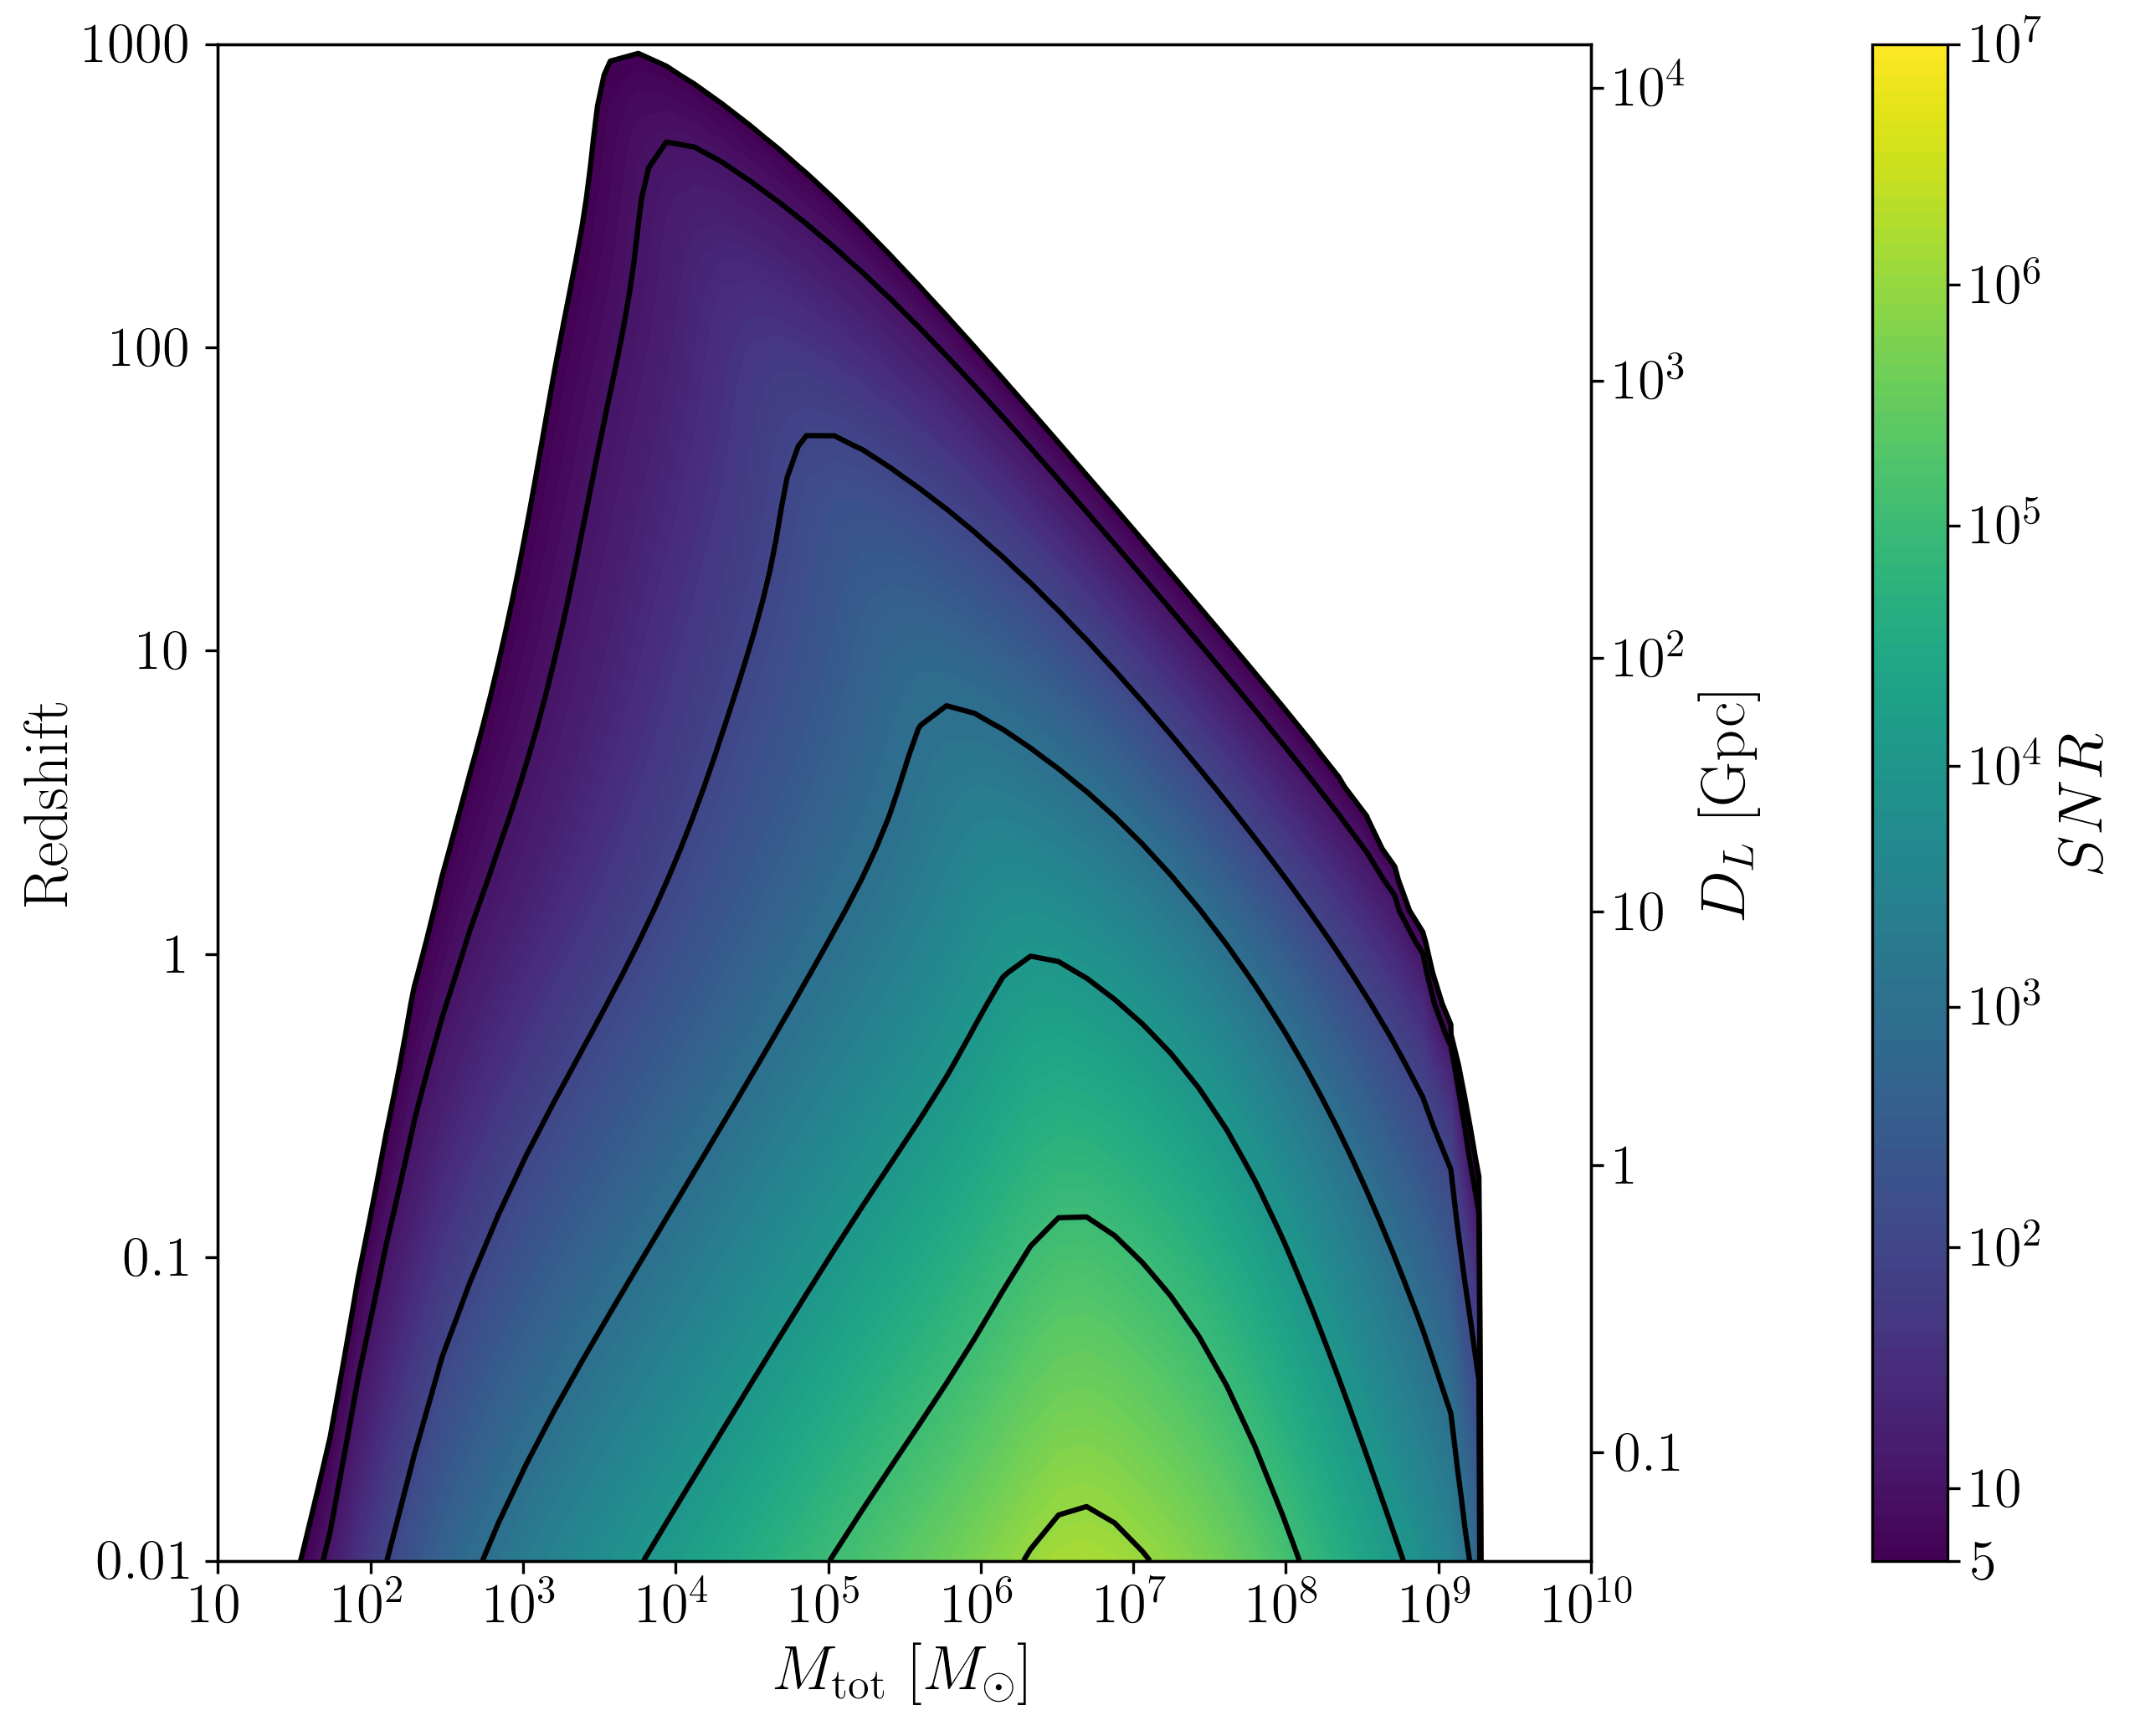

Model:  LISA_ESA ,  done. t = :  10.231818914413452


In [11]:
models = [0,1,2,3,4,5]
for model in models:
    instrument = Get_Instrument(model)
    source = Get_Source(model)
    start = time.time()
    [sample_x,sample_y,SNRMatrix] = snr.Get_SNR_Matrix(source,instrument,\
                                             var_x,sampleRate_x,var_y,sampleRate_y)
    end = time.time()
    #snr.Save_SNR(sample_x,sample_y,SNRMatrix,save_location,SNR_save_name,Sample_save_name)
    snrplot.Plot_SNR(source,instrument,var_x,sample_x,var_y,sample_y,SNRMatrix,dl_axis=True,smooth_contours=True)
    print('Model: ',instrument.name,',',' done. t = : ',end-start)